In [2]:
import os
import time
import tqdm
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, FancyArrowPatch
from matplotlib import colors
import logging
import yaml
import json
import joblib
from sklearn.impute import SimpleImputer
from scipy.stats.contingency import crosstab
import networkx as nx
from matplotlib.lines import Line2D
import umap
import itertools
import scipy
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns

sys.path.append(os.getcwd())
from functions.load_model import load_tolist
import functions.visualise as vis
import functions.process as proc
from functions.io import setup_logger, makedir
from functions import FeatureEngine
from numba import jit



/gpfs/soma_fs/home/boeger/usr/miniconda3/envs/sklearn-env2/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/gpfs/soma_fs/home/boeger/usr/miniconda3/envs/sklearn-env2/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/gpfs/soma_fs/home/boege

In [3]:
def padtoequalsize(arr1,arr2, dimstocompare = [-1]):
    arr1_shape = arr1.shape
    arr2_shape = arr2.shape
    arr1_pad_template = ([(0,0),]*len(arr1_shape))
    arr2_pad_template = ([(0,0),]*len(arr2_shape))
    for d in dimstocompare:
        pad_size = arr1_shape[d] - arr2_shape[d]
        arr1_pad_template = ([(0,0),]*len(arr1_shape))
        arr2_pad_template = ([(0,0),]*len(arr2_shape))
        arr1_pad_template[d] = (0,abs(pad_size))
        arr2_pad_template[d] = (0,pad_size)
        if pad_size > 0:
            arr2 = np.pad(arr2, arr2_pad_template,'constant', constant_values=np.nan)
        if pad_size < 0:
            arr1 = np.pad(arr1, arr1_pad_template,'constant', constant_values=np.nan)
    return arr1, arr2

Please provide where your files are stored and where you would like your data to be saved in the following section.

In [37]:
datestr = time.strftime("%Y%m%d-%HH%MM")
inpath = "/gpfs/soma_fs/scratch/src/boeger/PpaPred_eren" 
#inpath = '/gpfs/soma_fs/scratch/src/boeger/data_roca'

inpath_pattern = ['bac_data']
inpath_with_subfolders = True

WT_ordering = [0,1,2,3,4,5,6,7]#False#[1., 0., 2., 6., 8., 3., 4., 7., 5.]
plot = True

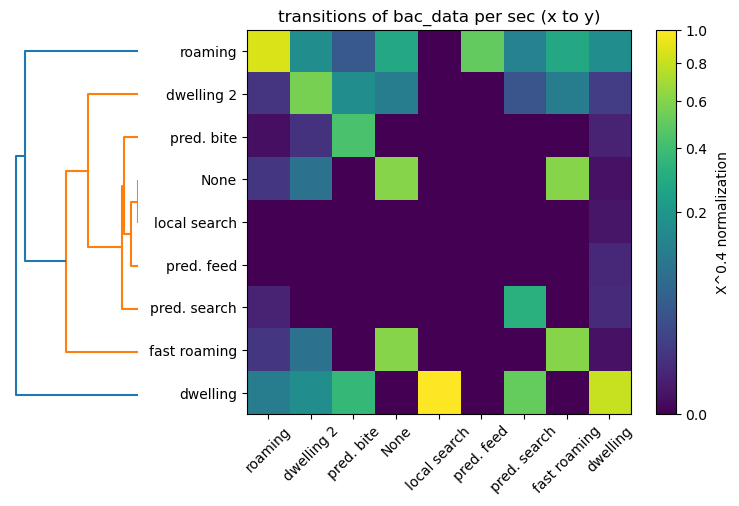

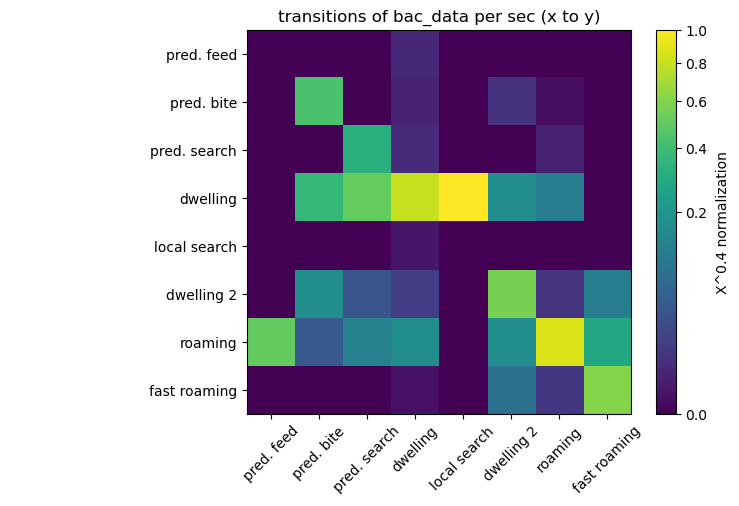

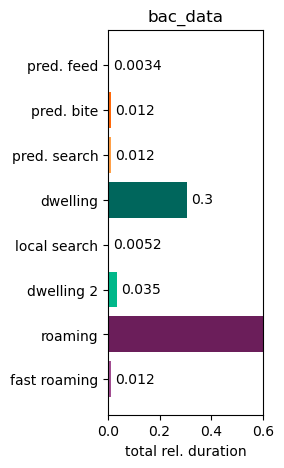

NameError: name 'y_batch' is not defined

In [38]:
#all_transitions = None
#all_durations = None
for data_str in inpath_pattern:
    ### I/O ################################################
    all_files = [os.path.join(root, name) for root, dirs, files in os.walk(inpath) for name in files if 'predicted' in os.path.basename(root) and data_str in os.path.basename(root)]
    loc_all = {os.path.basename(f):f for f in all_files if 'predicted.json' in f}
    loc_summ = [f for f in all_files if 'summary.csv' in f]
    loc_trans =  [f for f in all_files if 'transitions.csv' in f]
    loc_onoff = [f for f in all_files if 'onoff.json' in f]
    
    #outpath = os.path.commonpath(fpath.values())
    
    ### Configuration ################################################
    config = yaml.safe_load(open("config.yml", "r"))
    cluster_color = config['cluster_color']
    cluster_group = config['cluster_group_man']
    cluster_label = config['cluster_names']
    clu_group_label = {_:f'{_}, {__}' for _, __ in tuple(zip([c for c in cluster_label.values()],[g for g in cluster_group.values()]))}
    skip_already = config['settings']['skip_already']

    ### Load data ################################################
    #data_batch = load_tolist(fpath, droplabelcol=False)
    #data_batch_concat = pd.concat([d for d in data_batch], axis=0)
    
    #y_batch_concat = data_batch_concat['prediction']
    #y_batch = [d['prediction'] for d in data_batch]

    
    ### Batch summary ############################################
    for i,d in enumerate(loc_summ):
        summ_ = pd.read_csv(d)
        dev_ = (~summ_.isna()).astype(int)
        summ_ = summ_.fillna(0)
        #trans_col_ = [[c for c in fr_transition_],[c for c in fr_transition_]]
        
        if i == 0:
            summ = summ_
            devider = dev_
        else:
            summ += summ_
            devider += dev_
    summary = summ/devider
    #summary.to_csv(os.path.join(outpath, f'{data_str}_batch_summary.csv'))
    
    total_dur = summary.duration_mean*summary.duration_count
    total_dur_rel = total_dur/total_dur.sum()
    
    ### Batch transitions ############################################
    #batch_transitions = np.full((len(loc_trans),9,9), np.nan) # with shape recordings,cluster from, cluster to        
    for i,d in enumerate(loc_trans):
        fr_transition_ = pd.read_csv(d, index_col=0)
        #batch_transitions[i] = fr_transition_
        trans_col_ = [[c for c in fr_transition_],[c for c in fr_transition_]]
        if i == 0:
            fr_transition = fr_transition_
            trans_col = trans_col_
        elif trans_col_ == trans_col:
            #print('this')
            fr_transition += fr_transition_
        else:
            print('WARNING')

    # merge all transitions across animals and experiments
    #if all_transitions is None:
    #    all_transitions = np.array([batch_transitions])
    #else:
    #    all_transitions,batch_transitions = padtoequalsize(all_transitions, batch_transitions, [-3])
    #     all_transitions = np.concatenate([all_transitions,[batch_transitions]],axis=0)

    # calculate the normalised transition and cluster
    # cluster behaviors with single linkage
    Z = linkage(fr_transition, 'single', optimal_ordering=True)
    # extract closest cluster
    ordering = np.concatenate((Z[::-1,0],Z[:,1]))
    ordering = ordering[ordering<len(cluster_label)]-1
    # calculate normalised transitions
    fr_trans_norm = (fr_transition/fr_transition.sum(axis=0)).fillna(0).iloc[1:,1:]
    fr_transition_clust = fr_trans_norm.iloc[ordering,ordering]
    #fr_trans_norm.to_csv(os.path.join(outpath, f'{data_str}_batch_transitions_2.csv'), index=False)
    



    ### Batch durations ############################################
    #batch_durations = None
    for rec in loc_onoff:
        with open(rec,'r') as jf:
            onoff = json.load(jf)
        duration = pd.DataFrame(dtype='float64')
        for cluster in onoff: #for bout in cluster
            cluster_dur = []
            for bout in onoff[cluster]: #for bout in cluster
                cluster_dur.append(bout[1])
            duration = pd.concat([duration,pd.DataFrame([cluster_dur],index=[eval(cluster)],dtype='float64')],axis=0)
            
        cl_present = duration.index
        cl_range = range(min(cl_present), max(cl_present)+1)
        duration = duration.reindex(cl_range)
        
        #if batch_durations is None:
        #    batch_durations = np.array([duration.values])
        #else:
        #    batch_durations, duration = padtoequalsize(batch_durations, duration, [-1,-2])
        #    batch_durations = np.concatenate([batch_durations,[duration]],axis=0)
    
    #if all_durations is None:
    #    all_durations = np.array([batch_durations])
    #else:
    #    all_durations,batch_durations = padtoequalsize(all_durations, batch_durations, [-1,-2,-3])
    #    all_durations = np.concatenate([all_durations,[batch_durations]],axis=0)
    
        
    #############
    ### plots ###
    #############
    
    if plot:
        """
        transition_plot = vis.transition_plotter(fr_trans_norm.values, cluster_color, node_alpha=summary['duration_relative'].fillna(0).tolist())
        plt.text(1.5, -1, f'{data_str}\nN = {len(loc_trans)}', fontsize=12)
        plt.title(f"transitions of {data_str}")
        plt.savefig(os.path.join(outpath, f'{data_str}_batch_transitions.pdf'))
        plt.show()"""
        
        fig = plt.figure()
        axs1 = fig.add_axes([0, .895, .2, .805])
        axs1.axis('off')
        dn = dendrogram(Z, orientation='left',ax= axs1)
        axs2 = fig.add_axes([0.33, .9, .8, .8])
        im = axs2.imshow(fr_transition_clust,norm=colors.PowerNorm(.4,vmax=1))#vmin=0,vmax=.2)#
        axs2.set_xticks(range(len(cluster_group)))
        axs2.set_xticklabels([cluster_group[k] for k in ordering], rotation=45,ha="center")
        axs2.set_yticks(range(len(cluster_group)))
        axs2.set_yticklabels([cluster_group[k] for k in ordering])
        cbar = axs2.figure.colorbar(im, ax=axs2)
        cbar.ax.set_ylabel("X^0.4 normalization", rotation=90, labelpad= 6)
        axs2.set_title(f"transitions of {data_str} per sec (x to y)")
        #plt.savefig(os.path.join(outpath, f'{data_str}_batch_transitheatmap_clust.pdf'),bbox_inches = "tight")
        plt.show()
    
        if WT_ordering:
            fr_transition_WT = fr_trans_norm.iloc[WT_ordering,WT_ordering]
            fig = plt.figure()
            axs1 = fig.add_axes([0, .895, .2, .805])
            axs1.axis('off')
            #dn = dendrogram(Z, orientation='left',ax= axs1)
            axs2 = fig.add_axes([0.33, .9, .8, .8])
            im = axs2.imshow(fr_transition_WT,norm=colors.PowerNorm(.4,vmax=1))#vmin=0,vmax=.2)#
            axs2.set_xticks(range(len(cluster_group)-1))
            axs2.set_xticklabels([cluster_group[k] for k in WT_ordering], rotation=45,ha="center")
            axs2.set_yticks(range(len(cluster_group)-1))
            axs2.set_yticklabels([cluster_group[k] for k in WT_ordering])
            cbar = axs2.figure.colorbar(im, ax=axs2)
            cbar.ax.set_ylabel("X^0.4 normalization", rotation=90, labelpad= 6)
            axs2.set_title(f"transitions of {data_str} per sec (x to y)")
            #plt.savefig(os.path.join(outpath, f'{data_str}_batch_transitheatmap_WTclust.pdf'),bbox_inches = "tight")
            plt.show()
        
    
        
        fig, ax = plt.subplots(figsize=(2,5))
        b = ax.barh(range(len(total_dur_rel)),total_dur_rel, color=list(cluster_color.values())[1:])
        ax.set_yticks(range(len(cluster_group)-1))
        ax.set_yticklabels([cluster_group[k] for k in cluster_group][1:])
        ax.bar_label(b, label_type='edge', fmt='%.2g', padding=3)
        ax.invert_yaxis()
        plt.xlabel(f"total rel. duration")
        plt.title(data_str)
        plt.xlim(0,.6)
        #plt.savefig(os.path.join(outpath, f'{data_str}_batch_totaldur.pdf'),bbox_inches = "tight")
        plt.show()
    
        # Calculate onoff sets
        onoff = proc.onoff_dict(y_batch, labels =np.unique(y_batch_concat))
    
        fig = plt.figure(figsize=(.6*len(onoff.keys()),3), layout='constrained')
        for k in onoff.keys():
            if not np.isnan(k):
                durs = pd.DataFrame(onoff[k])[1]/30
                plt.boxplot(durs, positions=[k], widths=.5,sym='', patch_artist = True, boxprops={'facecolor':cluster_color[k]},medianprops={'color':'k'})
        plt.xticks(range(len(cluster_group)-1),[cluster_group[k] for k in cluster_group][1:], rotation=45)
        plt.ylabel("sec")
        plt.ylim(0,30)
        plt.title(f"duration of {data_str} (without fliers)")
        #plt.savefig(os.path.join(outpath, f'{data_str}_batch_durboxplot.pdf'),bbox_inches = "tight")
        plt.show()

In [36]:
fr_transition_WT

,0,1,2,3,4,5,6,7
0,0.685130,0.058117,0.127966,0.079458,0.017857,0.040934,0.106026,0.000000
1,0.110998,0.805655,0.040821,0.036669,0.116837,0.106503,0.045703,0.000000
2,0.103132,0.024234,0.551138,0.072245,0.011905,0.048821,0.091124,0.129429
3,0.030601,0.050876,0.082387,0.592437,0.101113,0.035120,0.094199,0.050000
4,0.000000,0.005872,0.003979,0.010689,0.512572,0.021648,0.007123,0.008000
5,0.014968,0.023671,0.049097,0.072614,0.095011,0.662825,0.037196,0.107714
6,0.041728,0.002904,0.071405,0.088495,0.042208,0.033200,0.537211,0.196667
7,0.000000,0.000000,0.007749,0.005895,0.000000,0.020257,0.008697,0.440857


In [29]:
cl_present

Index(['-1', '0', '1', '2', '5'], dtype='object')

In [6]:
def df_withnans_alignright(df_):
    df = df_.copy()
    for i in range(len(df.columns)):
        nulls = df.iloc[np.where(df.iloc[:,i].notnull())[0][-1]+1:,i]
        notnulls = df.iloc[:np.where(df.iloc[:,i].notnull())[0][-1],i]
        right_aligned = pd.concat([nulls,notnulls], axis=0).reset_index(drop=True)
        df.iloc[:,i] = right_aligned
    return df

In [ ]:
np.random.seed(96)
bout_all = pd.DataFrame([])
bout_pre_all = pd.DataFrame([])
y_pre_all = pd.DataFrame([])
bout_post_all = pd.DataFrame([])
y_post_all = pd.DataFrame([])
feat = 'velocity'
cl = 1
rdm_subset = np.random.choice(len(onoff[cl]), 100, replace=False)
rdm_ons =[]
for i,oo in enumerate(rdm_subset):
    rdm_ons.append(onoff[cl][oo][0])
    onset = onoff[cl][oo][0]
    offset = onoff[cl][oo][0]+onoff[cl][oo][1]
    bout = data_batch_concat.reset_index(drop=True)[onset:offset].reset_index(drop=True)
    if all(bout[feat].isnull()):
        print(i)
        continue
    bout_pre = data_batch_concat.reset_index(drop=True)[onset-60:onset].reset_index(drop=True)
    bout_post = data_batch_concat.reset_index(drop=True)[offset:offset+60].reset_index(drop=True)
    
    bout_all = pd.concat([bout_all,bout[feat]], axis=1)

    bout_pre_all = pd.concat([bout_pre_all,bout_pre[feat]], axis=1)
    y_pre_all = pd.concat([y_pre_all,bout_pre['prediction']], axis=1)
    bout_post_all = pd.concat([bout_post_all,bout_post[feat]], axis=1)
    y_post_all = pd.concat([y_post_all,bout_post['prediction']], axis=1)

bout_all.columns = list(range(len(bout_all.columns)))
bout_pre_all.columns = list(range(len(bout_pre_all.columns)))
y_pre_all.columns = list(range(len(y_pre_all.columns)))
y_pre_color = y_pre_all[:150].replace(cluster_color)
bout_post_all.columns = list(range(len(bout_post_all.columns)))
y_post_all.columns = list(range(len(y_post_all.columns)))
y_post_color = y_post_all[:150].replace(cluster_color)

bout_all_right = df_withnans_alignright(bout_all)

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
mask = data_batch_concat.prediction.isin([7])
#fig = px.lines(bout_all, color = y_bout_all, width=800, height=400)
fig = make_subplots(rows=1, cols=2)
for trace in bout_all:
    bout_ = bout_all[trace].iloc[:90].dropna().reset_index(drop=True)
    bout_r_ = bout_all_right[trace].iloc[-90:].dropna().reset_index(drop=True)
    pre_ = bout_pre_all[trace][y_pre_all[trace]==y_pre_all[trace].iloc[-1]].reset_index(drop=True)
    post_ = bout_post_all[trace][y_post_all[trace]==y_post_all[trace].iloc[-1]].reset_index(drop=True)
    
    fig.add_trace(go.Scatter(x=np.arange(len(bout_)), y=bout_, line=dict(color=cluster_color[cl]),mode='lines'),
                 row=1, col=1)
    fig.add_trace(go.Scatter(x=np.arange(-len(pre_),0), y=pre_, line=dict(color=y_pre_color[trace].iloc[-1]),mode='lines'),
                 row=1, col=1)
    fig.add_trace(go.Scatter(x=np.arange(-len(bout_r_),0), y=bout_r_, line=dict(color=cluster_color[cl]),mode='lines'),
                 row=1, col=2)
    fig.add_trace(go.Scatter(x=np.arange(len(post_)), y=post_, line=dict(color=y_post_color[trace].iloc[-1]),mode='lines'),
                 row=1, col=2)

    
mean_ = pd.concat([bout_pre_all,bout_all],axis=0).reset_index(drop=True).mean(axis=1).iloc[:150]
mean_r_ = pd.concat([bout_all_right, bout_post_all],axis=0).reset_index(drop=True).mean(axis=1).iloc[-150:]
fig.add_trace(go.Scatter(x=np.arange(-60,90), y=mean_, line=dict(color='black',width=3),mode='lines'),
                 row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(-90,60), y=mean_r_, line=dict(color='black',width=3),mode='lines'),
                 row=1, col=2)

fig.add_vline(x=0, line=dict(color="Grey",width=5))
fig.update_xaxes(dtick=15, title=dict(text='Time [frames]'))
fig.update_yaxes(range=[0, max(bout_all.max().max(),bout_pre_all.max().max(),bout_post_all.max().max())],title=dict(text=f'{feat}'))
fig.update_layout(
    width=1200,
    height=500,
    xaxis = dict(
        tickmode = 'linear',
        dtick = 15),
    showlegend=False,
    template='plotly_white',
    title=dict(text=f"Traces of {cluster_group[cl]} aligned at prediction onset (l) and offset (r)", font=dict(size=16), x =.5, xanchor='center'))
fig.show()

In [206]:
pd.concat([bout_pre_all,bout_all], axis=0).reset_index(drop=True)[:150]

,0,1,2,3,4,5,6,7,8,9
0,65.588663,11.045316,13.701244,15.620694,7.467817,103.740705,27.694622,3.327563,8.479545,21.531267
1,66.711265,11.239948,12.937549,15.368168,7.329733,106.623024,29.483240,3.390398,8.206798,20.878042
2,68.148248,10.668329,11.676886,15.223795,7.409337,105.923813,32.470621,3.368030,8.799378,20.061813
3,68.228593,10.736481,10.060535,15.568245,7.217975,108.797803,34.806850,3.042305,9.150252,20.430954
4,68.928750,9.335169,9.091620,15.155935,6.699869,108.152320,37.020580,2.183980,9.614971,21.444112
...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,21.774830,NaN,18.092826,13.132134,0.884922,16.044350,NaN,NaN
146,NaN,NaN,20.547505,NaN,20.713004,12.900061,1.931811,17.159261,NaN,NaN
147,NaN,NaN,18.787799,NaN,22.872326,13.441984,3.254090,17.320404,NaN,NaN
148,NaN,NaN,18.267775,NaN,25.064590,13.322782,3.873009,17.601522,NaN,NaN


In [5]:
onoff_ = pd.json_normalize(onoff).to_dict(orient='split')
onoff_rev = {}
for l,c in zip(onoff_['data'][0],onoff_['columns']):
    for oo in l:
        onoff_rev[oo[0]] = (c, oo[1])

onoff_rev_df = pd.DataFrame(onoff_rev).T
onoff_rev_df = onoff_rev_df.reindex(sorted(onoff_rev_df.index), axis=0)

onoff_rev_dfidx = onoff_rev_df.index.to_series().reset_index(drop=True)
prebout_idx = (onoff_rev_dfidx[onoff_rev_dfidx.isin(rdm_ons)].index - 1).tolist()

prebout_c, prebout_dur, prebout = onoff_rev_df.iloc[prebout_idx,0],onoff_rev_df.iloc[prebout_idx,1], onoff_rev_df.index[prebout_idx].to_list()

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8,5), sharey=True)
axs[0].plot(range(0,90),bout_all[:90], c=cluster_color[cl],alpha=.7)
for b,d,c in zip(prebout,prebout_dur,prebout_c):
    axs[0].plot(range(-d if d < 60 else -60,0),data_batch_concat.reset_index(drop=True).iloc[b:b+d][feat][-d if d < 60 else -60:], c=cluster_color[c],alpha=.7)
axs[0].plot(range(0,90),bout_all[:90].median(axis=1), c='#252422', linewidth=2)
axs[0].axvline(0)
axs[0].set_title("aligned beginning")
axs[1].plot(range(-90,0),bout_all_right[-90:], c=cluster_color[cl],alpha=.7)
axs[1].plot(range(-90,0),bout_all_right[-90:].median(axis=1), c='#252422', linewidth=2)
axs[1].axvline(0)
axs[1].set_title("aligned end")

/tmp/ipykernel_87572/3422461970.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  axs[0].plot(range(-d if d < 60 else -60,0),data_batch_concat.reset_index(drop=True).iloc[b:b+d][feat][-d if d < 60 else -60:], c=cluster_color[c],alpha=.7)


In [102]:
y_pre_all[trace][y_pre_all[trace]==y_pre_all[trace].iloc[-1]]

5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
41    1
42    1
43    1
44    1
45    1
46    1
47    1
48    1
49    1
50    1
51    1
52    1
53    1
54    1
55    1
56    1
57    1
58    1
59    1
Name: 19, dtype: int64

In [188]:
import scipy
from scipy.cluster.hierarchy import linkage, dendrogram
Z = linkage(fr_transition, 'single', optimal_ordering=True)
ordering = np.concatenate((Z[::-1,0],Z[:,1]))
ordering = ordering[ordering<=8]
fr_trans_norm = (fr_transition/fr_transition.sum(axis=0)).fillna(0)
fr_transition_clust = fr_transition.iloc[ordering,ordering]
fr_trans_clust_norm = 

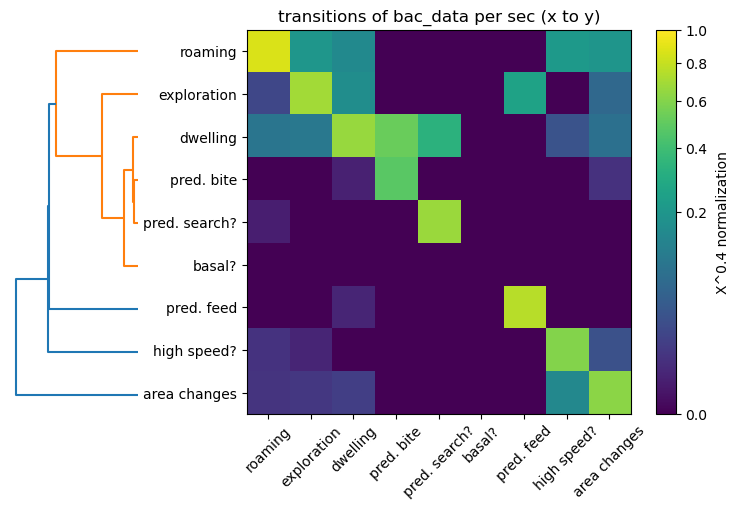

In [209]:
fig = plt.figure()
axs1 = fig.add_axes([0, .895, .2, .805])
axs1.axis('off')
dn = dendrogram(Z, orientation='left',ax= axs1)
axs2 = fig.add_axes([0.33, .9, .8, .8])
im = axs2.imshow(fr_transition_clust,norm=colors.PowerNorm(.4,vmax=1))#vmin=0,vmax=.2)#
axs2.set_xticks(range(len(cluster_group)-1))
axs2.set_xticklabels([cluster_group[k] for k in ordering], rotation=45,ha="center")
axs2.set_yticks(range(len(cluster_group)-1))
axs2.set_yticklabels([cluster_group[k] for k in ordering])
cbar = axs2.figure.colorbar(im, ax=axs2)
cbar.ax.set_ylabel("X^0.4 normalization", rotation=90, labelpad= 6)
axs2.set_title(f"transitions of {data_str} per sec (x to y)")
plt.savefig(os.path.join(out_predicted, os.path.basename(outpath)+'_batch_transitheatmap_clust.pdf'),bbox_inches = "tight")
plt.show()

In [191]:
fr_trans_norm

,0,1,2,3,4,5,6,7,8
0,0.75,0.00,0.000000,0.0,0.003497,0.000000,0.000000,0.000000,0.000000
1,0.00,0.48,0.000000,0.0,0.002607,0.007576,0.000000,0.000000,0.000000
2,0.00,0.00,0.666667,0.0,0.000000,0.000000,0.000000,0.001976,0.000000
3,0.00,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.00,0.52,0.333333,0.0,0.656351,0.082580,0.100569,0.094630,0.033333
5,0.00,0.00,0.000000,0.0,0.014454,0.618612,0.010769,0.008844,0.150000
6,0.25,0.00,0.000000,0.0,0.167750,0.065805,0.685893,0.021064,0.000000
7,0.00,0.00,0.000000,0.0,0.155341,0.195124,0.199367,0.865035,0.216667
8,0.00,0.00,0.000000,0.0,0.000000,0.030303,0.003401,0.008451,0.600000


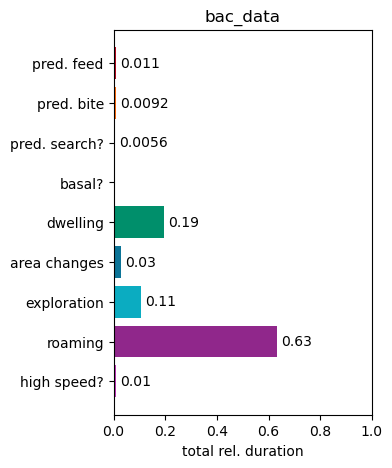

In [40]:
fig, ax = plt.subplots(figsize=(2/.6*1,5))
b = ax.barh(range(len(total_dur_rel)),total_dur_rel, color=list(cluster_color.values())[1:])
ax.set_yticks(range(len(cluster_group)-1))
ax.set_yticklabels([cluster_group[k] for k in cluster_group][1:])
ax.bar_label(b, label_type='edge', fmt='%.2g', padding=3)
ax.invert_yaxis()
plt.xlabel(f"total rel. duration")
plt.title(data_str)
plt.xlim(0,1)
plt.savefig(os.path.join(out_predicted, os.path.basename(outpath)+'_batch_totaldur.pdf'),bbox_inches = "tight")
plt.show()

In [ ]:
    data_describe = data_batch_concat.groupby(y_batch_concat).describe().T.loc[idx[:, ['mean','std','count']], :].sort_index(level=0).T
    dur_describe = pd.DataFrame(dur, columns=['duration']).groupby(transi).describe().T.loc[idx[:, ['mean','std','count']], :].sort_index(level=0).T
    dur_describe['duration','relative'] = pd.DataFrame(dur, columns=['duration']).groupby(transi).apply(lambda cd: cd.sum()/len(y_batch_concat))
    summary = pd.concat([dur_describe, data_describe], axis=1)
    summary.index.name = 'cluster'
    summary = summary.T.reset_index(drop=True).set_index(summary.T.index.map('_'.join)).T
    summary = summary.set_index(summary.index.astype(int))
    summary = summary.reindex([k for k in cluster_label if k != -1])
    summary.to_csv(os.path.join(out_predicted, os.path.basename(outpath)+'_batch_summary.csv'))

    #### Older Version
    
    for i,d in enumerate(data_batch):
        frame = d['prediction'].rolling(30).apply(lambda s: s.mode()[0])[29::30].values.flatten()
        trans_col_,fr_transition_ = crosstab(frame[1:], frame[:-1], levels=([k for k in cluster_label if k != -1],[k for k in cluster_label if k != -1]))
        #fr_transition_ = pd.read_csv() ##################################read transitions.csv should look like normal fr_transition, get trans_col from header
        if i == 0:
            fr_transition = fr_transition_
            trans_col = trans_col_
        if trans_col_ == trans_col:
            fr_transition += fr_transition_
        else:
            print('WARNING')
        #fr_transition/fr_transition.sum(axis=0)
    
    #othersum_axis0 = fr_transition.sum(axis=0)-fr_transition.diagonal()
    #transition_toother = fr_transition/othersum_axis0
    #transition_self = fr_transition.diagonal()/(othersum_axis0+fr_transition.diagonal())
    #np.fill_diagonal(transition_toother, 0)